# Assignment 2 – Zero-Shot Image Classification with Transformers

In this assignment, you will apply a pre-trained vision–language transformer (e.g. CLIP) to perform **zero-shot** classification on the Fashion-MNIST dataset—classifying each image without any task-specific training. You will build on the concepts from Assignment 1 by comparing this “off-the-shelf” approach to the CNN you previously trained.

You will:
1. **Load** the Fashion-MNIST images using PyTorch instead of Keras.
2. **Run a zero-shot baseline** with simple text prompts to set a performance reference.
3. **Engineer improved prompts** and measure the resulting accuracy gains.
4. **Visualise image embeddings** with UMAP to inspect class separability.
5. **Conduct one mini-experiment** of your choice.
6. **Summarise findings** and reflect on strengths and weaknesses of zero-shot transformers versus a trained CNN.

# 1. Loading the Fashion-MNIST Dataset

As in assignment 1, we'll load the Fashion-MNIST dataset, but this time using `torchvision.datasets` to ensure compatibility with the `transformers` library. We will also load our model and processor from the `transformers` library.

The transformers library allows us to use pre-trained models like CLIP, which can perform zero-shot classification by leveraging the text prompts we provide. There are two key objects we will use: the `CLIPModel` for the model itself and the `CLIPProcessor` for preparing our images and text prompts.

Since we are not actually training a model in this assignment, we will set the CLIP model to evaluation mode. If the model is designed to utilize features like dropout or batch normalization, setting it to evaluation mode ensures that these features behave correctly during inference (prediction). Setting the model to evaluaton mode also tells PyTorch that we don't have to compute gradients, which can save memory and speed up inference.

In order to speed up processing, we will also move the model to an "accelerator" if available. This is typically a GPU, but modern MacBooks also have an "Apple Silicon" accelerator that can be used for inference, called MPS (Metal Performance Shaders). If you are using a MacBook with Apple Silicon, you can use the MPS device for faster processing.

In [ ]:
# Uncomment and run if required
#!pip install transformers torchvision torch accelerate

In [4]:
from transformers import CLIPModel, CLIPProcessor
import torch

clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name) # remove "use_fast=False" as it caused error on my laptop

# Set model to evaluation mode, as we are not training it
clip_model.eval()

# Check for accelerators
device = "cpu" # Default to CPU
if torch.cuda.is_available():
    device = "cuda" # Use GPU if available
elif torch.backends.mps.is_available():
    device = "mps"

clip_model.to(device)
print(f"Using device: {device}")

2025-10-31 17:17:38.250568: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using device: cpu


Now we are ready to load the testing set from Fashion-MNIST. We will use the `torchvision.datasets.FashionMNIST` class to load the dataset. We do not need to apply any transformations to the images, as the `CLIPProcessor` ensures any input images are in the format that the model is trained on.

You should:

- [x] Use the `torchvision.datasets.FashionMNIST` class to load the *test* split of the dataset. Documentation is available [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
- [x] Create a PyTorch `DataLoader` to iterate over the dataset in batches. Use a batch size of 16 and set `shuffle=True` to randomise the order of the images. You will also need to supply the provided `collate_clip` function to the `DataLoader collate_fn` argument to ensure the images are processed correctly. Documentation for `DataLoader` is available [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [6]:
from torchvision import datasets
from torch.utils.data import DataLoader

CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

def collate_clip(batch):
    imgs, labels = zip(*batch) # Unzip the batch into images and labels
    proc = clip_processor(images=list(imgs),
                        return_tensors="pt",
                        padding=True) # Process images with CLIPProcessor
    # Send pixel_values to GPU/CPU now; labels stay on CPU for metrics
    return proc["pixel_values"].to(device), torch.tensor(labels)

# Load the Fashion-MNIST test dataset
#   we will not use the "transform" and "target_transform" parameters as CLIPProcessor will handle
#   image resizing, normaling and converting
test_dataset = datasets.FashionMNIST(
    root="./data",  # root directory to store dataset
    train=False,    # will not train
    download=True   # download from internet and store in root directory
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_clip
)

100%|██████████| 26421880/26421880 [00:05<00:00, 4847123.64it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 196491.70it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2806755.37it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6891885.41it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



If your code is correct, the following cell should show the first batch of images from the Fashion-MNIST dataset:

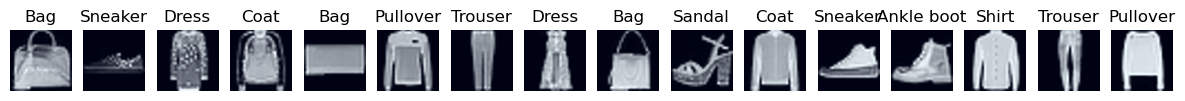

In [7]:
import matplotlib.pyplot as plt

# Display the first batch of images from `test_loader`

def show_batch(loader):
    images, labels = next(iter(loader))
    images = images.cpu()  # Move images to CPU for plotting
    # Renormalize to [0, 1] for visualization
    images = (images - images.min()) / (images.max() - images.min())
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(CLASS_NAMES[label.item()])
        ax.axis('off')
    plt.show()

show_batch(test_loader)

We’re now ready to run our zero-shot classification baseline!

# Brief Introduction to Zero-Shot Classification

In Assignment 1, we followed the typical machine-learning pipeline: we trained a CNN on the Fashion-MNIST dataset, using labelled examples to update the model’s weights. While effective, that approach requires a curated, task-specific training set—a luxury you don’t always have in practice.

Zero-shot classification flips the script.  A large vision–language model (VLM) such as **CLIP** is first pre-trained on hundreds of millions of image–text pairs scraped from the web.  Because it learns *joint* visual–textual embeddings, the model can later solve new tasks simply by “measuring” how similar an image is to a **text prompt** that describes each candidate class—without seeing a single task-labelled example.

**How it works**  
1. Feed an image through CLIP’s vision encoder → **image feature**.  
2. Feed a textual prompt (e.g. “a photo of a sandal”) through CLIP’s text encoder → **text feature**.  
3. Compute cosine similarity between the image feature and every class’s text feature.  
4. Pick the class whose prompt is most similar.

For our first attempt, we’ll use the bare class names as prompts, e.g.:

- "T-shirt/top"
- "Trouser"

### You should:

- [x] Build embeddings: use the `get_text_embeddings` helper function to create text embeddings for the class names.
- [x] Run inference: use the `get_image_embeddings` helper function to create image embeddings.
- [x] Compute cosine similarity: complete and use the `get_cosine_similarity` helper function to compute the cosine similarity between the image and text embeddings.
- [x] Make predictions: use the `get_predictions` helper function to get the predicted class for each image in the batch.

Note that for normalized vectors like the ones we are using, cosine similarity is equivalent to the dot product. This means we can use the handy formula `cosine_similarity = vector_a @ vector_b.T` to compute the similarity between the image and text embeddings.

In [8]:
def get_text_embeddings(class_names: list[str]) -> torch.Tensor:
    """    Get text embeddings for the given class names using CLIP.
    Args:
        class_names (list[str]): List of class names to encode.
    Returns:
        torch.Tensor: Normalized text embeddings for the class names.
    """
    tokenized = clip_processor(text=class_names,
                               padding=True,
                               return_tensors="pt").to(device)
    
    with torch.no_grad():
        text_embeddings = clip_model.get_text_features(**tokenized)

    text_feats = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

    return text_feats

def get_image_embeddings(images: torch.Tensor) -> torch.Tensor:
    """    Get image embeddings for the given images using CLIP.
    Args:
        images (torch.Tensor): Batch of images to encode.
    Returns:
        torch.Tensor: Normalized image embeddings for the images.
    """
    with torch.no_grad():
        image_embeddings = clip_model.get_image_features(pixel_values=images)

    image_feats = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

    return image_feats

In [9]:
import numpy as np

def get_cosine_similarity(image_feats: torch.Tensor, text_feats: torch.Tensor) -> np.ndarray:
    """
    Compute cosine similarity between image features and text features.
    Args:
        image_feats (torch.Tensor): Image features of shape (N, D).
        text_feats (torch.Tensor): Text features of shape (M, D).
    Returns:
        numpy.ndarray: Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    """
    image_feats = image_feats.cpu()  # Ensure image features are on CPU
    text_feats = text_feats.cpu()    # Ensure text features are on CPU

    # Compute cosine similarity, which is the dot product of normalized vectors
    return image_feats @ text_feats.T

def get_predictions(similarity: np.ndarray) -> np.ndarray:
    """
    Get predictions based on cosine similarity scores.
    Args:
        similarity (numpy.ndarray): Cosine similarity matrix of shape (N, M), where N is the number of images and M is the number of text prompts.
    Returns:
        numpy.ndarray: Predicted class indices for each image, shape (N,).
    """
    # Get the index of the maximum similarity for each image
    return np.argmax(similarity, axis=1)

With these functions complete, you are ready to run the zero-shot classification baseline. Complete the code to follow these steps:

- [x] Build text embeddings for the class names using the `get_text_embeddings` function (this only needs to be done once).
- [x] For each batch of images:
    - [x] Get image embeddings using the `get_image_embeddings` function.
    - [x] Compute cosine similarity between the image and text embeddings using the `get_cosine_similarity` function.
    - [x] Save the predictions so that we can build a confusion matrix later.
- [x] Report the accuracy of the predictions and the confusion matrix using the `accuracy_score` and `confusion_matrix` functions from `sklearn.metrics`.

In [10]:
CLASS_NAMES

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

baseline_accuracy:  0.6240


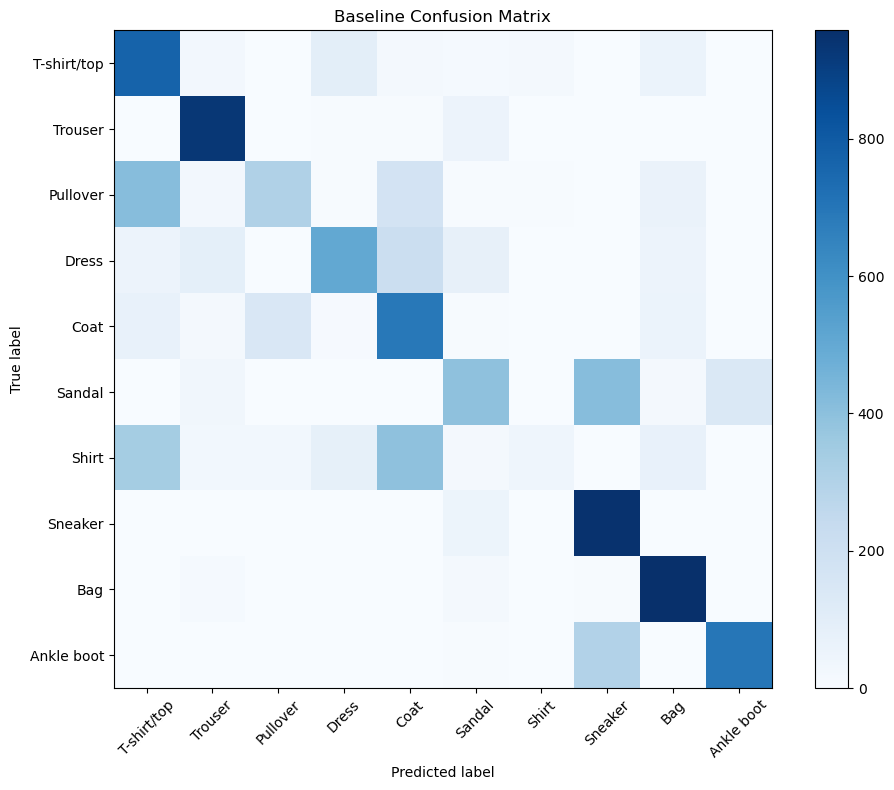

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Step 1: Build text embeddings once
baseline_text_embeddings = get_text_embeddings(CLASS_NAMES)

# Step 2: Loop over each batch of images
baseline_y_true, baseline_y_pred = [], []

for pixel_values, labels in test_loader:
    # 2a: Get image embeddings
    baseline_image_embeddings = get_image_embeddings(pixel_values)

    # 2b: Compute cosine similarity
    baseline_similarity = get_cosine_similarity(baseline_image_embeddings, baseline_text_embeddings)

    # 2c: Save the predictions
    baseline_predictions = get_predictions(baseline_similarity)

    # Append true and predicted labels
    baseline_y_true.extend(labels.numpy())
    baseline_y_pred.extend(baseline_predictions)

# Report the accuracy of the predictions
baseline_accuracy = accuracy_score(baseline_y_true, baseline_y_pred)
print(f"baseline_accuracy: {baseline_accuracy: .4f}")

# Report the confusion matrix with a customizable title
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(baseline_y_true, baseline_y_pred, CLASS_NAMES, title="Baseline Confusion Matrix")

Reflection: Consider the results. How does the performance of this zero-shot baseline compare to the CNN you trained in Assignment 1? What are the strengths and weaknesses of this approach?

Model Performance Comparison: CNN vs CLIP Zero-Shot

| Model Name         | Architecture / Approach                            | Accuracy (%) | Loss    | Notes                                      |
|--------------------|-----------------------------------------------------|--------------|---------|--------------------------------------------|
| **CNN Model**      | Conv2D(32) → Flatten → Dense(10), no dropout        | 89.27        | 0.360   | Strong baseline CNN without regularization |
| **Final CNN Model**| Conv2D(32) → Dropout(0.4) → Flatten → Dense(10)     | 89.60        | 0.311   | Best generalization with regularization    |
| **CLIP Zero-Shot** | Pretrained ViT-B/32, no training, prompt-based text | 62.40        | N/A     | Zero-shot classification using text prompts |

The CLIP Zero-Shot model achieved an accuracy of **62.40%** on the FashionMNIST dataset without any training, relying solely on pretrained vision-language alignment and class name prompts. In contrast, both CNN models were trained specifically on the dataset and achieved significantly higher accuracy (**89.27%** and **89.60%** respectively).

This highlights a key trade-off:

- **CLIP Zero-Shot** excels in flexibility and speed of deployment. It requires no labeled data or training, making it ideal for rapid prototyping or tasks with limited supervision. However, its performance is limited.

- **CNN Models** offer superior accuracy but require labeled data, training time, and careful tuning to generalize well.

Overall, CLIP provides a powerful baseline and a compelling starting point for tasks where labeled data is scarce or rapid iteration is needed. For production-level performance on specific datasets, traditional supervised models like CNNs still hold a strong advantage.


## Improving Zero-Shot Classification with Prompt Engineering

In the previous section, we directly used the class names as text prompts for zero-shot classification. However, we can often improve performance by crafting more descriptive prompts that better capture the visual characteristics of each class. For example, instead of just "T-shirt/top", we could use "a photo of a T-shirt" or "a photo of a top". This additional context can help the model make more accurate predictions.

In this section, we will experiment with more detailed prompts for each class to see if we can improve the zero-shot classification performance. You should:

- [x] Create a list of improved prompts for each class. For example, instead of just "T-shirt/top", you could use "a photo of a T-shirt" or "a photo of a top".
- [x] Use the `get_text_embeddings` function to create text embeddings for the improved prompts.
- [x] Run the zero-shot classification baseline again using the improved prompts and report the accuracy and confusion matrix.

Note: Take advantage of the confusion matrix above. If two classes are often confused, consider how you might improve the prompts to help the model distinguish them better.

The aim for this section is for you to improve the performance of the model. However, if you find that the performance does not improve significantly, you can still reflect on the process and consider how you might further refine the prompts with more effort.

improved_accuracy:  0.6095


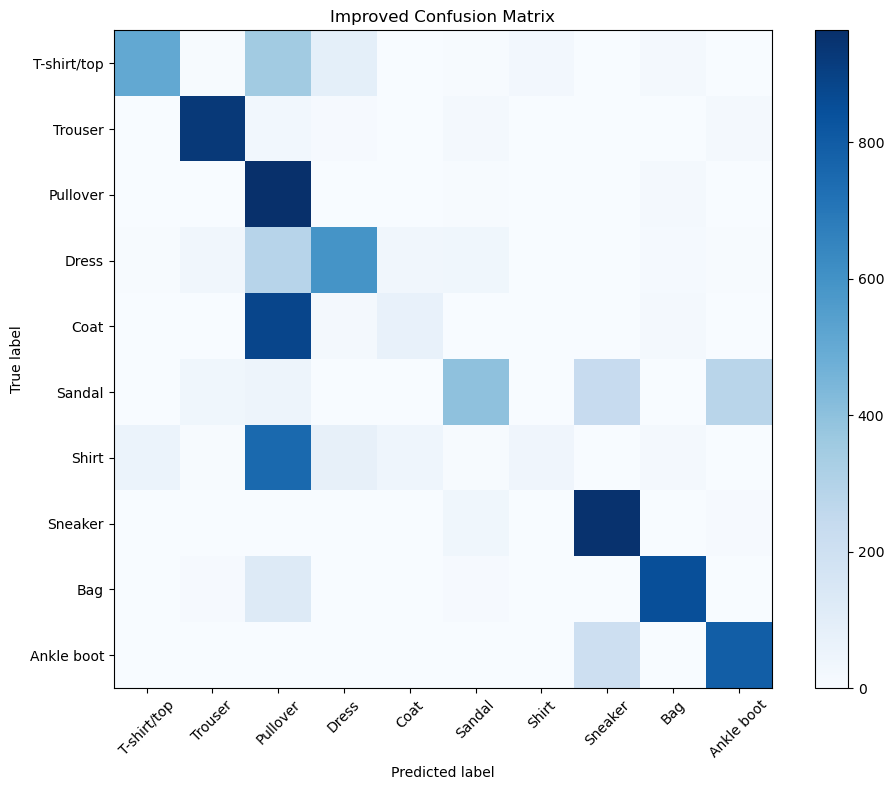

In [14]:
IMPROVED_PROMPTS = [
    "a photo of a T-shirt",
    "a photo of a trouser",
    "a photo of a pullover",
    "a photo of a dress",
    "a photo of a coat",
    "a photo of a sandal",
    "a photo of a shirt",
    "a photo of a sneaker",
    "a photo of a bag",
    "a photo of an ankle boot"
]

# Step 1: Build text embeddings once
improved_text_embeddings = get_text_embeddings(IMPROVED_PROMPTS)

# Step 2: Loop over each batch of images
improved_y_true, improved_y_pred = [], []

for pixel_values, labels in test_loader:
    # 2a: Get image embeddings
    improved_image_embeddings = get_image_embeddings(pixel_values)

    # 2b: Compute cosine similarity
    improved_similarity = get_cosine_similarity(improved_image_embeddings, improved_text_embeddings)

    # 2c: Save the predictions
    improved_predictions = get_predictions(improved_similarity)

    # Append true and predicted labels
    improved_y_true.extend(labels.numpy())
    improved_y_pred.extend(improved_predictions)

# Report the accuracy of the predictions
improved_accuracy = accuracy_score(improved_y_true, improved_y_pred)
print(f"improved_accuracy: {improved_accuracy: .4f}")

# Report the confusion matrix with a customizable title
plot_confusion_matrix(improved_y_true, improved_y_pred, CLASS_NAMES, title="Improved Confusion Matrix")

Reflection: How did your detailed prompts affect the zero-shot classification performance? Did you see a significant improvement compared to the baseline? What insights did you gain about the model's understanding of the classes? Do you think that with more effort you could further improve the performance? If so, how?

I experimented with more descriptive prompts in the zero-shot classification setup using CLIP, replacing short labels like `"T-shirt/top"` with phrases such as `"a photo of a T-shirt"` to mimic the kind of caption CLIP might encountered during traing.

However, the results showed a slight **drop in accuracy** from **62.40% (baseline)** to **60.95% (improved prompts)**. This suggests that more detailed prompts do not always lead to better performance — especially when the dataset (FashionMNIST) consists of grayscale, low-resolution images that differ significantly from the colour images that CLIP was trained on.

- Uniform prompt structures like `"a photo of..."` may make embeddings too similar.
- Natural prompts, e.g. a short-sleeved T-shirt, may better match CLIP’s learned representations of the trained datasets.

With more effort, performance could potentially be improved by:
- **Using multiple prompts per class** and averaging their embeddings.
- **Incorporating class-specific attributes** (e.g., `"a short-sleeved cotton shirt"`).

This experiment highlights the importance of prompt design and dataset alignment in zero-shot learning.

## Visualizing Image Embeddings with UMAP

To better understand how the model perceives the different classes, we can visualize the image embeddings using UMAP (Uniform Manifold Approximation and Projection). UMAP is a dimensionality reduction technique that helps us see how similar or dissimilar the embeddings are in a lower-dimensional space.

By visualizing the embeddings, we can gain insights into how well the model can distinguish certain images, even without considering the text prompts. This can help us identify clusters of similar images and see if there are any overlaps between classes.

You should:

- [x] Use the `get_image_embeddings` function to get the image embeddings for the entire test set.
- [x] Use UMAP to reduce the dimensionality of the image embeddings to 2D.
- [x] Plot the 2D embeddings, coloring each point by its true class label.

You may need to install the `umap-learn` library if you haven't already. You can do this by running `pip install umap-learn`.

In [ ]:
# Uncomment the following line to install UMAP if you haven't already
# !pip install umap-learn

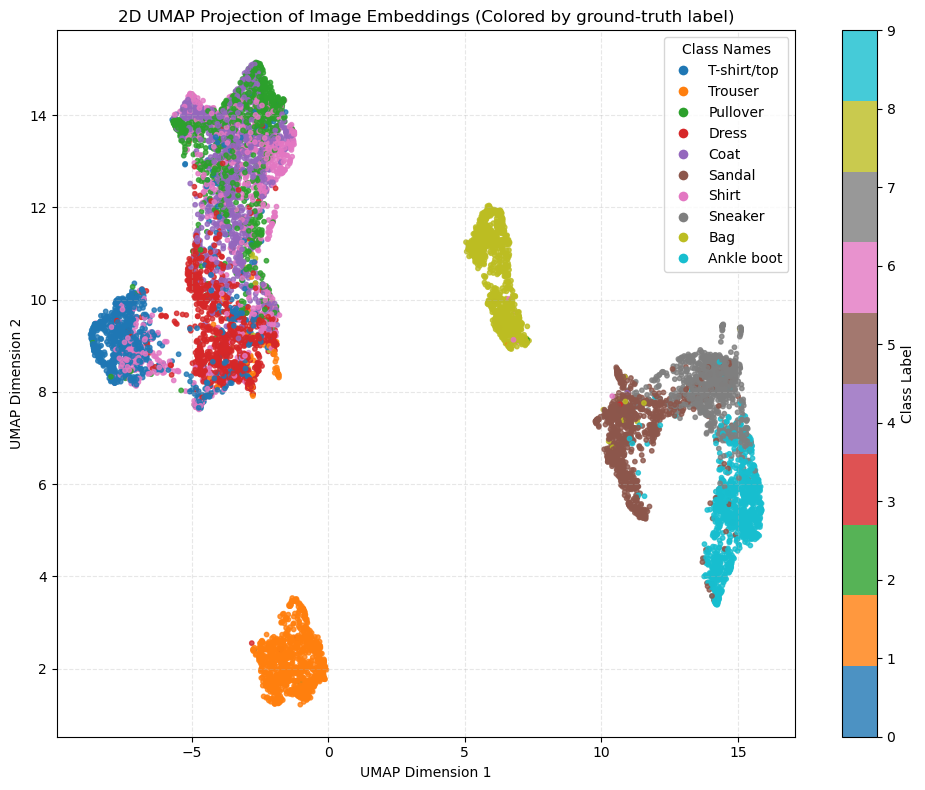

In [ ]:
# from umap import UMAP
from umap.umap_ import UMAP
from matplotlib.lines import Line2D

# ------------------------------------------------------------
# 1. Collect image embeddings
# ------------------------------------------------------------
all_img_emb = []
all_labels  = []

for pixel_values, labels in test_loader:
    image_embeddings = get_image_embeddings(pixel_values)
    all_img_emb.append(image_embeddings)
    all_labels.extend(labels.numpy())

# Stack all embeddings into a single array
all_img_emb = np.vstack(all_img_emb)
all_labels = np.array(all_labels)

# ------------------------------------------------------------
# 2. Fit UMAP
# ------------------------------------------------------------
umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine', random_state=42)
umap_emb = umap_model.fit_transform(all_img_emb)

# ------------------------------------------------------------
# 3. Plot coloured by ground-truth label
# ------------------------------------------------------------
# Create a color map and assign colors to each class
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(10)]

# Plot the UMAP embeddings
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    umap_emb[:, 0], umap_emb[:, 1],
    c=all_labels, cmap='tab10', s=10, alpha=0.8
)
plt.title("2D UMAP Projection of Image Embeddings (Colored by ground-truth label)")
plt.colorbar(scatter, ticks=range(10), label='Class Label')
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True, linestyle='--', alpha=0.3)

# Create custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=CLASS_NAMES[i],
                          markerfacecolor=colors[i], markersize=8)
                   for i in range(10)]
plt.legend(handles=legend_elements, title="Class Names", loc="best")

plt.tight_layout()
plt.show()

The UMAP embeddings allow us to see how separable or non-separable different classes are with our specific model. If two specific images are very similar, then they will be placed near each other on this graph. 

Reflection: Do you notice any challenges in distinguishing images based on this figure? Are there any types of clothing in the dataset which the model has no trouble distinguishing from the others?

**Hard to distingush images**

The UMAP plot reveals several overlapping clusters, indicating that the model struggles to clearly separate certain classes. 
Notably: (1) Coat vs Pullover vs Shirt and (2) Dress vs Coat. These categories often appear close together or intermixed. This suggests that the model finds it difficult to distinguish between upper-body garments with similar shapes. Low-resolution and grayscale inputs limit the model’s ability to pick up on fine-grained features like fabric texture, sleeve length, or neckline — which are crucial for distinguishing similar clothing types.

These challenges highlight the limitations of zero-shot models like CLIP when applied to datasets that differ from their training distribution.

**Easily to distingush Clothing Types**

Despite some confusion, the model shows strong separation for certain classes:
(1) Sneakers and Sandals: These footwear types form distinct clusters, likely due to their unique shapes and structural features.
(2) Bags: The model consistently places bags in a separate region, suggesting it can easily identify accessories versus clothing.
(3) Trousers: This class is often well-separated, possibly due to its unique shape

These results suggest that the model performs best when the clothing item has a distinct silhouette or structural features that stand out even in grayscale.

## Mini-Experiment

In this section, you will conduct a mini-experiment of your choice to further explore the capabilities of zero-shot classification with transformers. This can be anything you'd like, but here are some ideas to get you started.

### A. Alternative Model

So far we have been utilizing OpenAI's CLIP model for zero-shot classification. However, there are many other vision–language models available in the `transformers` library that you can experiment with. For example, there are larger CLIP models such as [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14), and open-source versions such as [laion/CLIP-ViT-B-32-laion2B-s34B-b79K](https://huggingface.co/laion/CLIP-ViT-B-32-laion2B-s34B-b79K). You can also search huggingface [here](https://huggingface.co/models?sort=trending&search=clip) to find other models that might be suitable for zero-shot classification.

You can try using a different model to see if it improves the zero-shot classification performance. You should:
- [ ] Load a different model and processor from the `transformers` library.
- [ ] Run the zero-shot classification baseline with the new model and report the accuracy and confusion matrix.
- [ ] Reflect on the performance of the new model compared to the original CLIP model
  - How does the new model perform compared to the original CLIP model?
  - Do you notice any differences in the types of errors made by the new model?

### B. Multiple-Description Classification

Another interesting experiment is to explore multiple-description classification. *This involves providing multiple text prompts for each class, allowing the model to choose the most relevant one. For example, instead of just "T-shirt/top", you could provide "a photo of a T-shirt", "a photo of a top", and "a photo of a shirt". This can help the model better understand the class and increases the likelihood of a correct prediction. You should:

- [x] Create a list of multiple prompts for each class.
- [x] Use the `get_text_embeddings` function to create text embeddings for the multiple prompts.
- [x] Run the zero-shot classification baseline again using the multiple prompts and report the accuracy and confusion matrix.
- [x] Consider the model to be correct if it guesses *any* of the prompts belonging to the correct class.

### C. Top-K Classification

In some classification tasks, it can be useful to consider if the right answer is among the top K (e.g. top 3) predictions. This can be particularly useful in cases where the model is uncertain or when there are multiple similar classes. You should:

- [x] Modify the `get_predictions` function to return the top K predictions for each image.
- [x] Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions.
- [x] Report the accuracy and confusion matrix for the top K predictions. Report at least two different values of K (e.g. K=2 and K=4).

### D. Other Ideas

You are welcome to come up with your own mini-experiment! Explain your idea in the report and implement it. Did it work as you expected? What did you learn from it?

In [ ]:
# Mini-Experiment B. Multiple-Description Classification

MULTI_PROMPTS = {
    "T-shirt/top": [
        "a photo of a t-shirt",
        "a picture of a short-sleeve top",
        "a casual shirt",
        "a cotton top"
    ],
    "Trouser": [
        "a photo of trousers",
        "a pair of pants",
        "long pants",
        "a picture of slacks"
    ],
    "Pullover": [
        "a photo of a pullover",
        "a long-sleeve sweater",
        "a knitted top",
        "a picture of a jumper"
    ],
    "Dress": [
        "a photo of a dress",
        "a picture of a gown",
        "a sleeveless dress",
        "a long dress"
    ],
    "Coat": [
        "a photo of a coat",
        "a winter jacket",
        "a trench coat",
        "a picture of outerwear"
    ],
    "Sandal": [
        "a photo of sandals",
        "a pair of open shoes",
        "summer footwear",
        "a picture of flip-flops"
    ],
    "Shirt": [
        "a photo of a shirt",
        "a button-up shirt",
        "a collared shirt",
        "a long-sleeve shirt"
    ],
    "Sneaker": [
        "a photo of sneakers",
        "a pair of athletic shoes",
        "running shoes",
        "a picture of trainers"
    ],
    "Bag": [
        "a photo of a bag",
        "a handbag",
        "a shoulder bag",
        "a picture of a purse"
    ],
    "Ankle boot": [
        "a photo of ankle boots",
        "a pair of short boots",
        "leather boots",
        "a picture of booties"
    ]
}

In [35]:
# Map prompts to Class
all_prompts = [prompt for prompts in MULTI_PROMPTS.values() for prompt in prompts]
prompt_to_class = [class_label for class_label, prompts in MULTI_PROMPTS.items() for prompt in prompts]

for label, prompt in zip(prompt_to_class, all_prompts):
    print(f"{label:15} : {prompt}")

T-shirt/top     : a photo of a t-shirt
T-shirt/top     : a picture of a short-sleeve top
T-shirt/top     : a casual shirt
T-shirt/top     : a cotton top
Trouser         : a photo of trousers
Trouser         : a pair of pants
Trouser         : long pants
Trouser         : a picture of slacks
Pullover        : a photo of a pullover
Pullover        : a long-sleeve sweater
Pullover        : a knitted top
Pullover        : a picture of a jumper
Dress           : a photo of a dress
Dress           : a picture of a gown
Dress           : a sleeveless dress
Dress           : a long dress
Coat            : a photo of a coat
Coat            : a winter jacket
Coat            : a trench coat
Coat            : a picture of outerwear
Sandal          : a photo of sandals
Sandal          : a pair of open shoes
Sandal          : summer footwear
Sandal          : a picture of flip-flops
Shirt           : a photo of a shirt
Shirt           : a button-up shirt
Shirt           : a collared shirt
Shirt     

multiprompts_accuracy:  0.6158


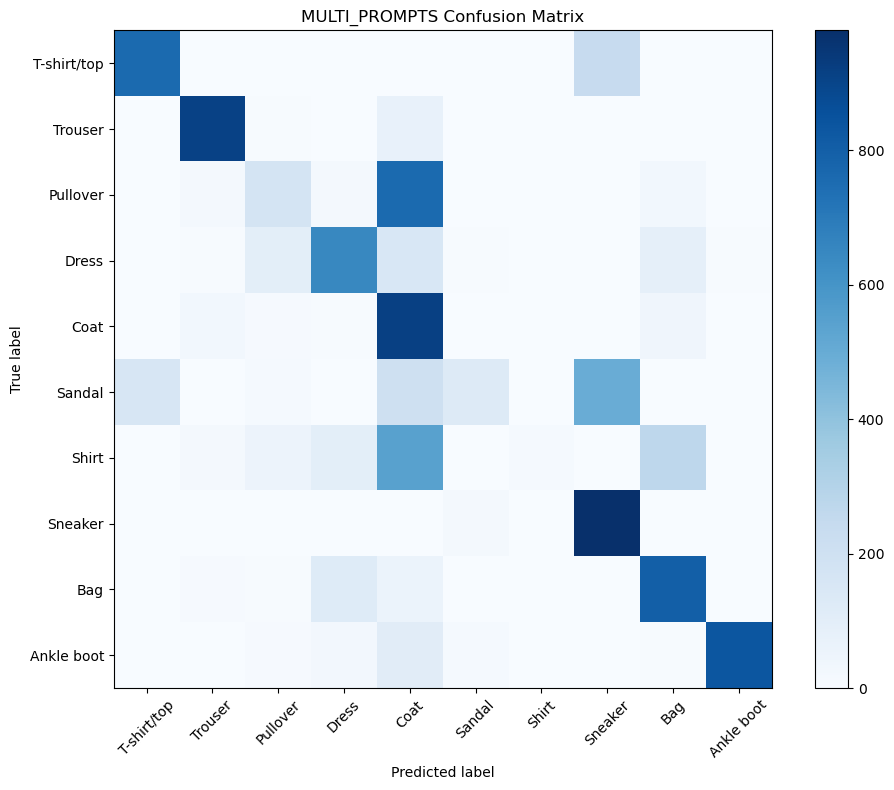

In [34]:
# Step 1: Build text embeddings once
multiprompts_text_embeddings = get_text_embeddings(all_prompts)

# Step 2: Loop over each batch of images
multiprompts_y_true, multiprompts_y_pred = [], []

for pixel_values, labels in test_loader:
    # 2a: Get image embeddings
    multiprompts_image_embeddings = get_image_embeddings(pixel_values)

    # 2b: Compute cosine similarity
    multiprompts_similarity = get_cosine_similarity(multiprompts_image_embeddings, multiprompts_text_embeddings)

    # 2c: Get best matching prompt index and save the predictions
    best_matching_indices = torch.argmax(multiprompts_similarity, dim=1)
    multiprompts_predictions = [prompt_to_class[i] for i in best_matching_indices]

    # Append true and predicted labels
    mp = list(MULTI_PROMPTS.keys())
    multiprompts_y_true.extend([mp[i] for i in labels.numpy()])
    multiprompts_y_pred.extend(multiprompts_predictions)

# Report the accuracy of the predictions
multiprompts_accuracy = accuracy_score(multiprompts_y_true, multiprompts_y_pred)
print(f"multiprompts_accuracy: {multiprompts_accuracy: .4f}")

# Report the confusion matrix with a customizable title
plot_confusion_matrix(multiprompts_y_true, multiprompts_y_pred, mp, title="MULTI_PROMPTS Confusion Matrix")

In [ ]:
# Mini-Experiment B. Multiple-Description Classification - Refined prompts

REFINED_PROMPTS = {
    "Pullover": [
        "a knitted pullover sweater",
        "a long-sleeve wool sweater",
        "a cozy winter pullover",
        "a thick knitted top"
    ],
    "Coat": [
        "a long trench coat",
        "a winter overcoat",
        "a heavy outerwear jacket",
        "a photo of a coat with buttons"
    ],
    "Sandal": [
        "a pair of open-toe sandals",
        "beach flip-flops",
        "strappy summer sandals",
        "flat sandals with straps"
    ],
    "Sneaker": [
        "a pair of athletic sneakers",
        "running shoes with laces",
        "sporty footwear",
        "Nike-style trainers"
    ],
    "Shirt": [
        "a button-up dress shirt",
        "a collared long-sleeve shirt",
        "a formal office shirt",
        "a cotton shirt with buttons"
    ],
    "T-shirt/top": [
        "a short-sleeve cotton t-shirt",
        "a casual crew-neck top",
        "a plain white t-shirt",
        "a fitted summer top"
    ]
}

MULTI_PROMPTS_REFINED = MULTI_PROMPTS.copy()
MULTI_PROMPTS_REFINED.update(REFINED_PROMPTS)

In [37]:
# Map prompts to Class
all_prompts = [prompt for prompts in MULTI_PROMPTS_REFINED.values() for prompt in prompts]
prompt_to_class = [class_label for class_label, prompts in MULTI_PROMPTS_REFINED.items() for prompt in prompts]

for label, prompt in zip(prompt_to_class, all_prompts):
    print(f"{label:15} : {prompt}")

T-shirt/top     : a short-sleeve cotton t-shirt
T-shirt/top     : a casual crew-neck top
T-shirt/top     : a plain white t-shirt
T-shirt/top     : a fitted summer top
Trouser         : a photo of trousers
Trouser         : a pair of pants
Trouser         : long pants
Trouser         : a picture of slacks
Pullover        : a knitted pullover sweater
Pullover        : a long-sleeve wool sweater
Pullover        : a cozy winter pullover
Pullover        : a thick knitted top
Dress           : a photo of a dress
Dress           : a picture of a gown
Dress           : a sleeveless dress
Dress           : a long dress
Coat            : a long trench coat
Coat            : a winter overcoat
Coat            : a heavy outerwear jacket
Coat            : a photo of a coat with buttons
Sandal          : a pair of open-toe sandals
Sandal          : beach flip-flops
Sandal          : strappy summer sandals
Sandal          : flat sandals with straps
Shirt           : a button-up dress shirt
Shirt      

refinedprompts_accuracy:  0.6528


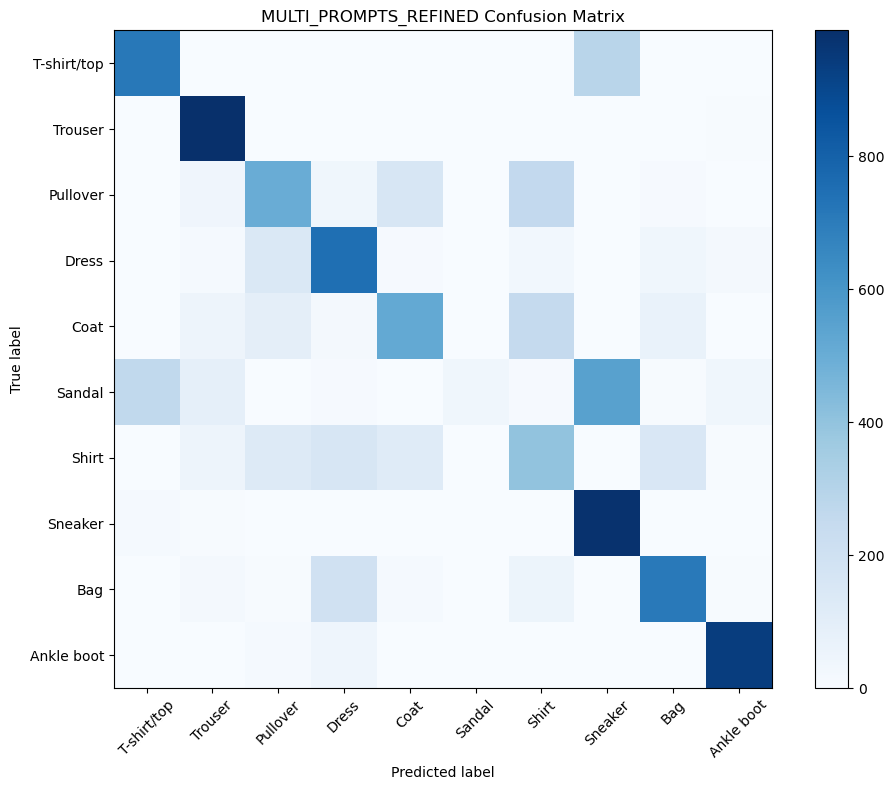

In [38]:
# Step 1: Build text embeddings once
refinedprompts_text_embeddings = get_text_embeddings(all_prompts)

# Step 2: Loop over each batch of images
refinedprompts_y_true, refinedprompts_y_pred = [], []

for pixel_values, labels in test_loader:
    # 2a: Get image embeddings
    refinedprompts_image_embeddings = get_image_embeddings(pixel_values)

    # 2b: Compute cosine similarity
    refinedprompts_similarity = get_cosine_similarity(refinedprompts_image_embeddings, refinedprompts_text_embeddings)

    # 2c: Get best matching prompt index and save the predictions
    best_matching_indices = torch.argmax(refinedprompts_similarity, dim=1)
    refinedprompts_predictions = [prompt_to_class[i] for i in best_matching_indices]

    # Append true and predicted labels
    mp = list(MULTI_PROMPTS_REFINED.keys())
    refinedprompts_y_true.extend([mp[i] for i in labels.numpy()])
    refinedprompts_y_pred.extend(refinedprompts_predictions)

# Report the accuracy of the predictions
refinedprompts_accuracy = accuracy_score(refinedprompts_y_true, refinedprompts_y_pred)
print(f"refinedprompts_accuracy: {refinedprompts_accuracy: .4f}")

# Report the confusion matrix with a customizable title
plot_confusion_matrix(refinedprompts_y_true, refinedprompts_y_pred, mp, title="MULTI_PROMPTS_REFINED Confusion Matrix")

In [43]:
# Mini-Experiment C. Top-K Classification - One Batch

mp = list(MULTI_PROMPTS_REFINED.keys())
topk_accuracy = {}

def compute_topk_accuracy_per_batch(similarity, labels, prompt_to_class, mp, top_k, show_predictions=False):
    # Modify the get_predictions function to return the top K predictions for each image
    topk_indices = torch.topk(similarity, k=top_k, dim=1).indices
    topk_predictions = [[prompt_to_class[i] for i in top] for top in topk_indices]

    # Modify the accuracy calculation to consider the model correct if the true class is among the top K predictions
    topk_count = 0
    for true_label_idx, choices in zip(labels.numpy(), topk_predictions):
        true_label = mp[true_label_idx]
        if true_label in choices:
            topk_count += 1
        
        if show_predictions:
            print(f"Image {true_label_idx}: True label = {true_label}, Top-{top_k} predictions = {choices}")
    
    topk_acc = topk_count / len(labels)
    return topk_acc

for k in [2, 3, 4]:
    acc = compute_topk_accuracy_per_batch(refinedprompts_similarity, labels, prompt_to_class, mp, top_k=k, show_predictions=True)
    topk_accuracy[k] = acc
    print(f"Top-{k} Accuracy: {acc:.4f}")

Image 4: True label = Coat, Top-2 predictions = ['Shirt', 'Coat']
Image 7: True label = Sneaker, Top-2 predictions = ['Sneaker', 'Sneaker']
Image 8: True label = Bag, Top-2 predictions = ['Bag', 'Bag']
Image 3: True label = Dress, Top-2 predictions = ['Shirt', 'Pullover']
Image 4: True label = Coat, Top-2 predictions = ['Shirt', 'Pullover']
Image 1: True label = Trouser, Top-2 predictions = ['Dress', 'Dress']
Image 8: True label = Bag, Top-2 predictions = ['Bag', 'Bag']
Image 1: True label = Trouser, Top-2 predictions = ['Trouser', 'Trouser']
Image 5: True label = Sandal, Top-2 predictions = ['Sneaker', 'Ankle boot']
Image 5: True label = Sandal, Top-2 predictions = ['Sneaker', 'Sneaker']
Image 1: True label = Trouser, Top-2 predictions = ['Trouser', 'Trouser']
Image 2: True label = Pullover, Top-2 predictions = ['Shirt', 'Pullover']
Image 2: True label = Pullover, Top-2 predictions = ['Coat', 'Pullover']
Image 5: True label = Sandal, Top-2 predictions = ['Ankle boot', 'Ankle boot']
Im

In [ ]:
# Mini-Experiment C. Top-K Classification - Complete Dataset

# Accuracy across the whole dataset
def compute_topk_accuracy(test_loader, text_embeddings, prompt_to_class, mp, top_k):
    topk_count = 0      # Number of samples where the true label was found in the top K predictions
    correct_total = 0   # Total number of samples evaluated

    for pixel_values, labels in test_loader:
        image_embeddings = get_image_embeddings(pixel_values)

        similarity = get_cosine_similarity(image_embeddings, text_embeddings)

        topk_indices = torch.topk(similarity, k=top_k, dim=1).indices
        topk_predictions = [[prompt_to_class[i] for i in top] for top in topk_indices]

        for true_label_idx, choices in zip(labels.numpy(), topk_predictions):
            true_label = mp[true_label_idx]
            if true_label in choices:
                topk_count += 1
    
        correct_total += len(labels)    # len(labels) is the number of samples in this batch
    topk_acc = topk_count / correct_total
    return topk_acc

mp = list(MULTI_PROMPTS_REFINED.keys())
topk_accuracy = {}

for k in [2, 3, 4]:
    acc = compute_topk_accuracy(test_loader, refinedprompts_text_embeddings, prompt_to_class, mp, top_k=k)
    topk_accuracy[k] = acc
    print(f"Top-{k} Accuracy: {acc:.4f}")

Top-2 Accuracy: 0.7611
Top-3 Accuracy: 0.8072
Top-4 Accuracy: 0.8452


### Short Report

In this section, you will write a short report summarizing your findings from the mini-experiment. The report should include the following sections:

- **Introduction**: Briefly describe the mini-experiment you conducted and its objectives.
- **Methodology**: Explain the steps you took to conduct the experiment, including any modifications you made to the code or model.
- **Results**: Present the results of your experiment.
- **Discussion**: Reflect on the performance of the model and the implications of your findings. Consider the strengths and weaknesses of zero-shot transformers versus a trained CNN.

## Mini-Experiment Report: Evaluating Zero-Shot Image Classification with Prompt Refinement and Top-K Accuracy

**Introduction**

This mini-experiment explores the performance of a zero-shot image classification model using prompt engineering techniques. The primary objective was to assess how multiple textual prompts and Top-K evaluation strategies influence classification accuracy, and compare the effectiveness of zero-shot transformers with traditional supervised models such as CNNs.

**Methodology**

The experiment was conducted in four stages:

(1) Baseline Multi-Prompt Classification: I evaluated a zero-shot transformer model using a set of baseline textual prompts (MULTI_PROMPTS) to classify images. Each class was described using multiple natural language phrases, and the model selected the most semantically similar prompt to each image embedding.

(2) Prompt Refinement via Confusion Matrix: Based on the confusion matrix from the baseline results, I identified commonly confused classes and refined the prompts (MULTI_PROMPTS_REFINED) to improve clarity and distinctiveness.

(3) Top-K Classification on a Single Batch: Using the refined prompts, I computed Top-K accuracy (K = 2, 3, 4) on a single batch of test images. This allowed me to observe how often the correct label appeared among the model’s top predictions.

(4) Top-K Classification on the Full Dataset: I extended the Top-K evaluation to the entire test dataset to obtain a more comprehensive view of model performance.

**Results**

| Experiment | Description                          | Accuracy |
|------------|--------------------------------------|----------|
| (1)        | Baseline multi-prompt classification | 0.6158   |
| (2)        | Refined prompts classification       | 0.6528   |
| (3)        | Top-K (1 batch)                      |          |
|            | – Top-2 Accuracy                     | 0.6250   |
|            | – Top-3 Accuracy                     | 0.7500   |
|            | – Top-4 Accuracy                     | 0.8750   |
| (4)        | Top-K (full dataset)                 |          |
|            | – Top-2 Accuracy                     | 0.7611   |
|            | – Top-3 Accuracy                     | 0.8072   |
|            | – Top-4 Accuracy                     | 0.8452   |

**Discussion**

The experiment demonstrates several key insights:

1. Prompt Engineering Matters: Refining prompts based on confusion matrix analysis led to a noticeable improvement in accuracy (from 61.58% to 65.28%). This highlights the importance of prompt clarity and specificity in zero-shot learning.

2. Top-K Evaluation Reveals Model Confidence Beyond Top-1: While Top-1 accuracy may underrepresent the model’s understanding, Top-K metrics show that the correct label often appears among the top predictions. For instance, Top-4 accuracy on the full dataset reached 84.52%, indicating strong semantic alignment even when the top prediction is incorrect.

3. Zero-Shot Transformers vs. Trained CNNs

I compared the zero-shot transformer’s performance to a previously trained CNN model on the same dataset in Assignment 1. The CNN architecture consisted of a Conv2D(32) layer followed by Dropout(0.4), Flatten, and a Dense(10) output layer. This model achieved 89.6% accuracy with a loss of 0.311, demonstrating strong generalization and low error.

In contrast, the zero-shot transformer achieved up to 84.52% Top-4 accuracy without any task-specific training. While its Top-1 accuracy was lower, the Top-K results show that it often ranked the correct label among its top predictions.

- Strengths of the zero-shot model: Zero-shot models offer flexibility, require no task-specific training, and can generalize across domains using language supervision. This makes them especially useful for rapid prototyping or for tasks where labeled data is limited.

- Limitations: Their performance depends heavily on the quality and specificity of prompts. Without fine-tuning, they may struggle with subtle visual distinctions or ambiguous class definitions. Compared to the trained CNN model from Assignment 1, the supervised CNN model outperformed the zero-shot transformer in Top-1 accuracy on well-defined tasks.

This comparison highlights the trade-off between flexibility and precision: zero-shot models offer rapid deployment and broad generalization, while trained CNNs provide higher accuracy for well-defined tasks.


🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 02/11/2025`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb)
    * The Lab 4 notebook (labs/lab_4.ipynb)
    * The Lab 5 notebook (labs/lab_5.ipynb)
    * The Lab 6 notebook (labs/lab_6.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-7-help-ml`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.